In [1]:
import pandas as pd
import psycopg2
import traceback


class Conexion_BD:
    def __init__(self, host,port,name,user,password):
        self.host = host
        self.port = port
        self.name = name
        self.user = user
        self.password = password
        self.estado = "Correcto"
        self.conexion = ''
        self.Estado_Conexion = self.crear_conexion()

    def crear_conexion(self):
        cxn = True
        try:
            self.conexion = psycopg2.connect(
                host=self.host,
                port=self.port,
                database=self.name,
                user=self.user,
                password=self.password)
        except Exception as e:
            self.estado = f"Error de conexion: \nServer: {self.host}\nDATABASE: {self.name}"
            cxn = False
        return cxn

    def consultar_bd(self, consulta):
        df = None
        self.estado = "Correcto"
        try:
            cursor = self.conexion.cursor()
            cursor.execute(consulta)
            records = cursor.fetchall()
            columnas = [desc[0] for desc in cursor.description]
            df = pd.DataFrame(records, columns=columnas)
            cursor.close()
        except Exception as e:
            self.estado = f"Error en consulta: {traceback.format_exc()}"
        return df

    def cerrar_conexion(self):
        self.conexion.close()        
        self.Estado_Conexion = False


In [2]:
db_host = 'database-iot-pry20241050.clguogmy6dz7.us-east-2.rds.amazonaws.com'
db_port = 5432
db_name = 'iotdatabase'
db_user = 'pry20241050'
db_password = 'tH6gn6c59OX9'

In [3]:
bd = Conexion_BD(db_host,db_port,db_name,db_user,db_password)

In [4]:
bd.Estado_Conexion

True

In [12]:
consulta = """SELECT * 
FROM medicion 
WHERE date BETWEEN '2024-09-01' AND '2024-09-30' """

In [13]:
consulta_sensores = """SELECT A.id,B.name FROM sensor A LEFT JOIN tipo_gas B ON A.gas_type_id = B.id"""

In [14]:
df_datos = bd.consultar_bd(consulta)

In [15]:
df_sensores = bd.consultar_bd(consulta_sensores)

In [16]:
df_datos = df_datos[["id","date","sensor_id","value"]]

In [17]:
df_merge = pd.merge(df_datos,df_sensores,how='left',left_on='sensor_id',right_on='id')

In [18]:
df_merge = df_merge[["id_x","date","name","value"]]

In [19]:
df_merge["fecha"] = pd.to_datetime(df_merge["date"])

In [20]:
df_merge['fecha'] = df_merge['fecha'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [21]:
df_merge["fecha"] = pd.to_datetime(df_merge["date"])
df_merge['fecha'] = df_merge['fecha'].dt.tz_convert('Etc/GMT+5')

In [22]:
df_merge = df_merge[["id_x","fecha","name","value"]]

In [23]:
df_merge.fecha.dt.day.unique()

array([ 3,  5,  6, 31,  7,  8,  9, 10, 11, 12, 13])

In [24]:
df_merge

,id_x,fecha,name,value
0,17920,2024-09-03 18:33:31-05:00,MONOXIDO DE CARBONO,0.0000
1,17921,2024-09-03 18:33:31-05:00,DIOXIDO DE NITROGENO,2.5860
2,17922,2024-09-03 18:33:31-05:00,DIOXIDO DE AZUFRE,27.6790
3,17923,2024-09-03 18:33:31-05:00,MATERIAL PARTICULADO 2.5,29.9320
4,17924,2024-09-03 18:33:31-05:00,MATERIAL PARTICULADO 10,29.9320
...,...,...,...,...
48561,65680,2024-09-13 16:20:15-05:00,MONOXIDO DE CARBONO,947.0970
48562,65681,2024-09-13 16:20:15-05:00,DIOXIDO DE NITROGENO,228.2830
48563,65682,2024-09-13 16:20:15-05:00,DIOXIDO DE AZUFRE,56.8280
48564,65683,2024-09-13 16:20:15-05:00,MATERIAL PARTICULADO 2.5,26.4550


In [26]:
df_final=df_merge.query("fecha.dt.day>=6 and fecha.dt.day <= 13")

In [28]:
df_final.fecha.dt.day.unique()

array([ 6,  7,  8,  9, 10, 11, 12, 13])

In [29]:
df_final.shape

(47660, 4)

In [112]:
df_29_agosto = df_merge.query("fecha.dt.day==29").copy()
df_30_agosto = df_merge.query("fecha.dt.day==30").copy()
df_31_agosto = df_merge.query("fecha.dt.day==31").copy()

In [113]:
df_29_agosto.shape

(2922, 4)

In [114]:
df_30_agosto.shape

(1422, 4)

In [115]:
df_31_agosto.shape

(4404, 4)

In [40]:
df_31_agosto.fecha.dt.hour.unique()

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

In [80]:
ruta = r"C:\Users\ROGGER\Desktop\Datos Senamhi\Datos31.xlsx"

In [81]:
datos31 = pd.read_excel(ruta)

In [83]:
datos31 = datos31.drop(columns={"fecha"})

In [84]:
datos31["hora"] = datos31["hora"].astype(str)

In [85]:
datos31['hour'] = datos31['hora'].str.split(':').str[0].astype(int)

In [30]:
df_final['fecha_hora'] = df_final['fecha'].dt.floor('H')

C:\Users\ROGGER\AppData\Local\Temp\ipykernel_15700\1320145301.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_final['fecha_hora'] = df_final['fecha'].dt.floor('H')
C:\Users\ROGGER\AppData\Local\Temp\ipykernel_15700\1320145301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['fecha_hora'] = df_final['fecha'].dt.floor('H')


In [31]:
df_promedio = df_final.groupby(['name', 'fecha_hora'])['value'].mean().reset_index()

In [32]:
df_promedio.loc[df_promedio["name"]=='TEMPERATURA',"name"] = "T"

In [33]:
df_promedio.loc[df_promedio["name"]=='DIOXIDO DE AZUFRE',"name"] = "SO2"

In [34]:
df_promedio.loc[df_promedio["name"]=='DIOXIDO DE NITROGENO',"name"] = "NO2"

In [35]:
df_promedio.loc[df_promedio["name"]=='MONOXIDO DE CARBONO',"name"] = "CO"

In [36]:
df_promedio.loc[df_promedio["name"]=='MATERIAL PARTICULADO 10',"name"] = "PM10"

In [37]:
df_promedio.loc[df_promedio["name"]=='MATERIAL PARTICULADO 2.5',"name"] = "PM2.5"

In [124]:
masa_no2 = 46.01
masa_so2 = 64.06
masa_co = 28.01

In [125]:
df_promedio['value'] = df_promedio['value'].astype(float)

In [126]:
df_promedio.loc[df_promedio["name"] == 'NO2', "value"] = 0.0409 * masa_no2 * df_promedio.loc[df_promedio["name"] == 'NO2', "value"]

In [127]:
df_promedio.loc[df_promedio["name"] == 'SO2', "value"] = 0.0409 * masa_so2 * df_promedio.loc[df_promedio["name"] == 'SO2', "value"]

In [128]:
df_promedio.loc[df_promedio["name"] == 'CO', "value"] = 0.0409 * masa_co * df_promedio.loc[df_promedio["name"] == 'CO', "value"]

In [38]:
copia = df_promedio.copy()

In [39]:
copia['fecha_hora'] = pd.to_datetime(copia['fecha_hora'], format='%d/%m/%Y %H:%M')
pivot_df = copia.pivot(index='fecha_hora', columns='name', values='value')
pivot_df.reset_index(inplace=True)

In [40]:
pivot_df['fecha'] = pivot_df['fecha_hora'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [41]:
pivot_df['hora'] = pivot_df['fecha_hora'].dt.strftime('%H:00')

In [42]:
pivot_df = pivot_df[["fecha","hora","PM2.5","PM10","CO","NO2","SO2"]]

In [48]:
pivot_df[["fecha","hora","PM2.5","PM10","CO","NO2","SO2"]]

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2
0,2024-09-06 00:00:00,00:00,65.509465,66.974279,0.0,0.143674,74.741163
1,2024-09-06 01:00:00,01:00,76.646375,78.390609,0.0,-0.022,55.572328
2,2024-09-06 02:00:00,02:00,105.011952,109.014661,0.0,-0.022,49.989871
3,2024-09-06 03:00:00,03:00,79.86535,82.310567,0.0,-0.022,49.012683
4,2024-09-06 04:00:00,04:00,73.150063,75.800048,0.0,-0.022,47.581905
...,...,...,...,...,...,...,...
179,2024-09-13 12:00:00,12:00,74.770796,75.576796,4893.886833,281.971593,45.269204
180,2024-09-13 13:00:00,13:00,55.354481,55.746704,1900.962148,288.538556,48.500889
181,2024-09-13 14:00:00,14:00,52.321778,52.723794,3429.739794,338.912603,51.641873
182,2024-09-13 15:00:00,15:00,35.931889,38.835852,3830.449037,327.995593,54.408685


In [50]:
pivot_df.query("fecha == '2024-09-06'")

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2


In [70]:
pivot_df.loc[pivot_df["CO"]<=0,"CO"] = 0.003852

In [71]:
pivot_df.query("fecha == '2024-09-06 12:00:00'")

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2
11,2024-09-06 12:00:00,12:00,64.702296,66.064074,0.003852,6.233556,63.491037


In [72]:
pivot_df.loc[pivot_df["CO"]<=0]

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2


In [74]:
respaldo = pivot_df.copy()

In [125]:
pivot_df = respaldo.copy()

In [111]:
#convertir en mg en vez de ug
pivot_df["PM2.5"] = pivot_df["PM2.5"]/1000
pivot_df["PM10"] = pivot_df["PM10"]/1000
pivot_df["CO"] = pivot_df["CO"]/1000
pivot_df["NO2"] = pivot_df["NO2"]/1000
pivot_df["SO2"] = pivot_df["SO2"]/1000

In [149]:
columns_to_round = ["PM2.5", "PM10", "CO", "NO2", "SO2"]

# Convertir a numérico y luego redondear
pivot_df[columns_to_round] = pivot_df[columns_to_round].apply(pd.to_numeric, errors='coerce').round(2)


In [148]:
round(pivot_df["PM2.5"].max(),2)

3321.22

In [127]:
pivot_df.shape

(184, 7)

In [128]:
pivot_df["fecha"] = pd.to_datetime(pivot_df["fecha"])

In [129]:
pivot_df["dia"] = pivot_df["fecha"].dt.day

In [150]:
pivot_df.query("`PM2.5` >= 150")

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2,dia
77,2024-09-09 06:00:00,06:00,152.00,170.12,1594.79,200.31,53.10,9
78,2024-09-09 07:00:00,07:00,171.47,194.47,651.61,196.88,49.13,9
170,2024-09-13 03:00:00,03:00,3321.22,4126.41,1357.08,233.94,15.81,13
171,2024-09-13 04:00:00,04:00,426.65,430.13,1188.73,233.78,22.64,13


In [169]:
por_dia = pivot_df.groupby("dia")[["PM2.5", "PM10", "CO", "NO2", "SO2"]].mean().reset_index()

In [173]:
por_dia.loc[por_dia["dia"]!=13,"PM2.5"] += por_dia.loc[por_dia["dia"]!=13,"PM2.5"]*0.20

In [175]:
por_dia.loc[por_dia["dia"]!=13,"PM10"] += por_dia.loc[por_dia["dia"]!=13,"PM10"]*0.80

In [179]:
por_dia.loc[por_dia["dia"]!=13,"NO2"] += por_dia.loc[por_dia["dia"]!=13,"NO2"]*0.20

In [185]:
por_dia.loc[por_dia["dia"]==13,"NO2"] += por_dia.loc[por_dia["dia"]==13,"NO2"]*0.10

In [216]:
por_dia.loc[por_dia["dia"]==6,"CO"] += por_dia.loc[por_dia["dia"]==6,"CO"]*0.12

In [220]:
por_dia.loc[por_dia["dia"]==6,"NO2"] += por_dia.loc[por_dia["dia"]==6,"NO2"]*0.12

In [243]:
respaldo = por_dia.copy()

In [244]:
new_row = {"dia": 14, "PM2.5": 290, "PM10": 289, "CO": 1782, "NO2": 339, "SO2": 50.09} 
por_dia.loc[8] = new_row

In [246]:
new_row = {"dia": 15, "PM2.5": 234, "PM10": 223, "CO": 1142, "NO2": 312, "SO2": 20.09} 
por_dia.loc[9] = new_row

In [247]:
new_row = {"dia": 16, "PM2.5": 290, "PM10": 289, "CO": 3455, "NO2": 532, "SO2": 40.09} 
por_dia.loc[10] = new_row

In [263]:
por_dia.loc[por_dia["dia"]>13,"PM2.5"] -= por_dia.loc[por_dia["dia"]>13,"PM2.5"]*0.1234

In [269]:
por_dia.loc[por_dia["dia"]>13,"PM10"] -= por_dia.loc[por_dia["dia"]>13,"PM10"]*0.0234

In [281]:
por_dia.loc[por_dia["dia"]==16,"PM10"] -= por_dia.loc[por_dia["dia"]==16,"PM10"]*0.0234

In [285]:
por_dia.loc[por_dia["dia"]>13,"CO"] -= por_dia.loc[por_dia["dia"]>13,"CO"]*0.0234

In [289]:
por_dia.loc[por_dia["dia"]>13,"NO2"] -= por_dia.loc[por_dia["dia"]>13,"NO2"]*0.1234

In [297]:
por_dia.loc[por_dia["dia"]==16,"NO2"] -= por_dia.loc[por_dia["dia"]==16,"NO2"]*0.1234

In [299]:
por_dia.loc[por_dia["dia"]>13,"SO2"] -= por_dia.loc[por_dia["dia"]>13,"SO2"]*0.0234

In [306]:
por_dia["fecha"] = pd.to_datetime(por_dia["dia"].astype(str) + '-09-2024', format='%d-%m-%Y', errors='coerce').dt.strftime("%Y-%m-%d")

In [308]:
respaldo = por_dia.copy()

In [312]:
por_dia["PM2.5"] = por_dia["PM2.5"].round(2)
por_dia["PM10"] = por_dia["PM10"].round(2)
por_dia["CO"] = por_dia["CO"].round(2)
por_dia["NO2"] = por_dia["NO2"].round(2)
por_dia["SO2"] = por_dia["SO2"].round(2)

In [314]:
exportar = por_dia[["fecha","PM2.5","PM10","CO","NO2","SO2"]].copy()

In [317]:
exportar

name,fecha,PM2.5,PM10,CO,NO2,SO2
0,2024-09-06,125.29,133.48,560.21,90.21,59.77
1,2024-09-07,136.90,144.02,715.23,116.41,61.94
2,2024-09-08,108.97,110.08,868.84,259.78,55.94
3,2024-09-09,128.40,135.60,860.95,275.41,58.77
4,2024-09-10,121.18,125.51,1423.19,297.14,55.46
5,2024-09-11,121.92,127.20,2381.80,339.96,52.89
6,2024-09-12,104.81,109.29,2100.41,337.01,49.26
7,2024-09-13,286.65,335.33,2261.96,360.28,40.31
8,2024-09-14,173.39,216.88,1525.55,290.21,48.92
9,2024-09-15,139.91,167.35,977.65,267.10,19.62


In [326]:
exportar.to_excel(r"C:\Users\ROGGER\Desktop\Estudio-Agosto\RESULTADOS\RESULTADOS.xlsx",index=False)

In [321]:
#graficos

In [106]:
import pandas as pd
df = pd.read_excel(r"C:\Users\ROGGER\Desktop\Estudio-Agosto\RESULTADOS\RESULTADOS.xlsx")

In [107]:
exportar = df.iloc[:10]

In [108]:
exportar

,fecha,PM2.5,PM10,CO,NO2,SO2
0,2024-09-06,125.29,133.48,560.21,90.21,59.77
1,2024-09-07,136.90,144.02,715.23,116.41,61.94
2,2024-09-08,108.97,110.08,868.84,259.78,55.94
3,2024-09-09,128.40,135.60,860.95,275.41,58.77
4,2024-09-10,121.18,125.51,1423.19,297.14,55.46
5,2024-09-11,121.92,127.20,2381.80,339.96,52.89
6,2024-09-12,104.81,109.29,2100.41,337.01,49.26
7,2024-09-13,286.65,335.33,2261.96,360.28,40.31
8,2024-09-14,173.39,216.88,1525.55,290.21,48.92
9,2024-09-15,139.91,167.35,977.65,267.10,19.62


In [109]:
exportar["PM10"] = exportar["PM10"].astype("float")

C:\Users\ROGGER\AppData\Local\Temp\ipykernel_30064\4096153813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exportar["PM10"] = exportar["PM10"].astype("float")


In [115]:
gas = "PM10"
limite = 150

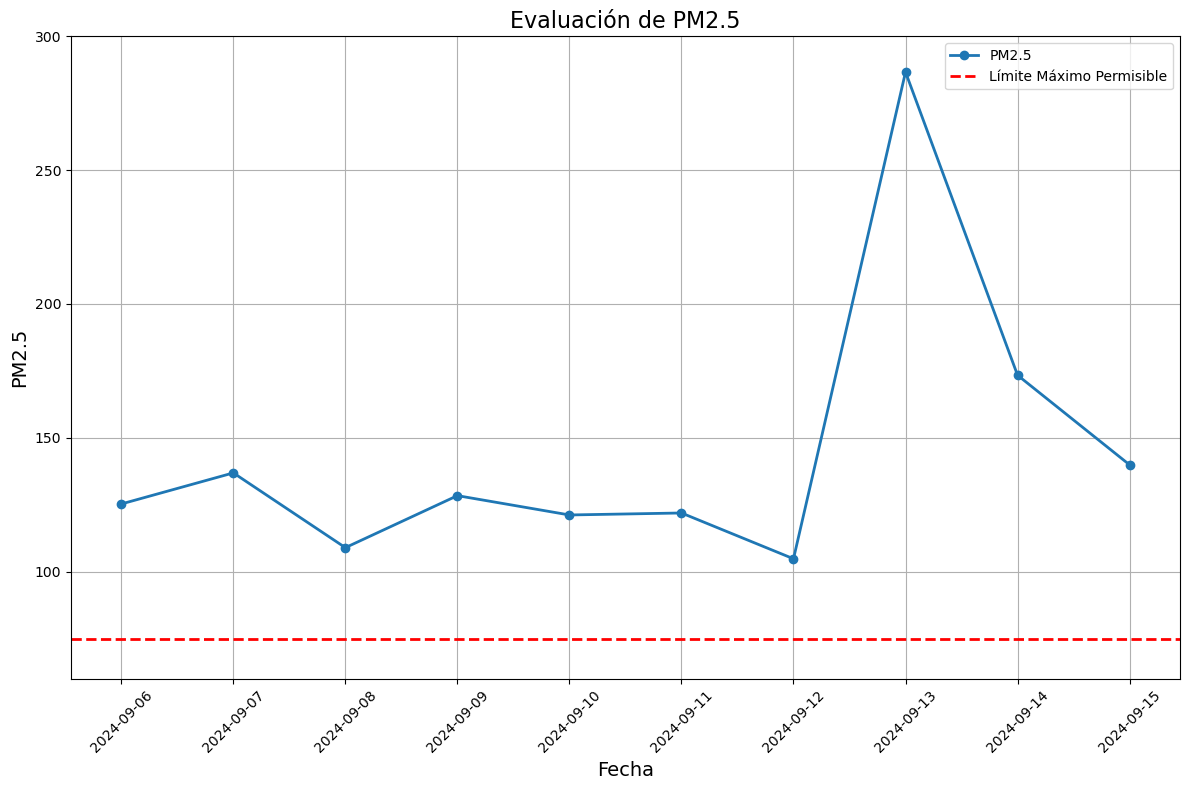

In [112]:
import matplotlib.pyplot as plt

# Crear el gráfico
plt.figure(figsize=(12, 8))

# Graficar PM2.5
plt.plot(exportar['fecha'], exportar[gas], color='tab:blue', linestyle='-', marker='o', linewidth=2, label=f'{gas}')

# Agregar línea horizontal para el límite máximo permitido
plt.axhline(y=limite, color='red', linestyle='--', linewidth=2, label='Límite Máximo Permisible')
plt.ylim(bottom=60, top=300)  # Ajusta estos valores según tus datos y el límite

# Configurar etiquetas y título
plt.xlabel('Fecha', fontsize=14)
plt.ylabel(f'{gas}', fontsize=14)
plt.title(f'Evaluación de {gas}', fontsize=16)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Exportar a archivo de imagen
plt.tight_layout()
plt.savefig(f'{gas}_grafico_con_limite_nuevo.png', dpi=300)

# Mostrar el gráfico
plt.show()


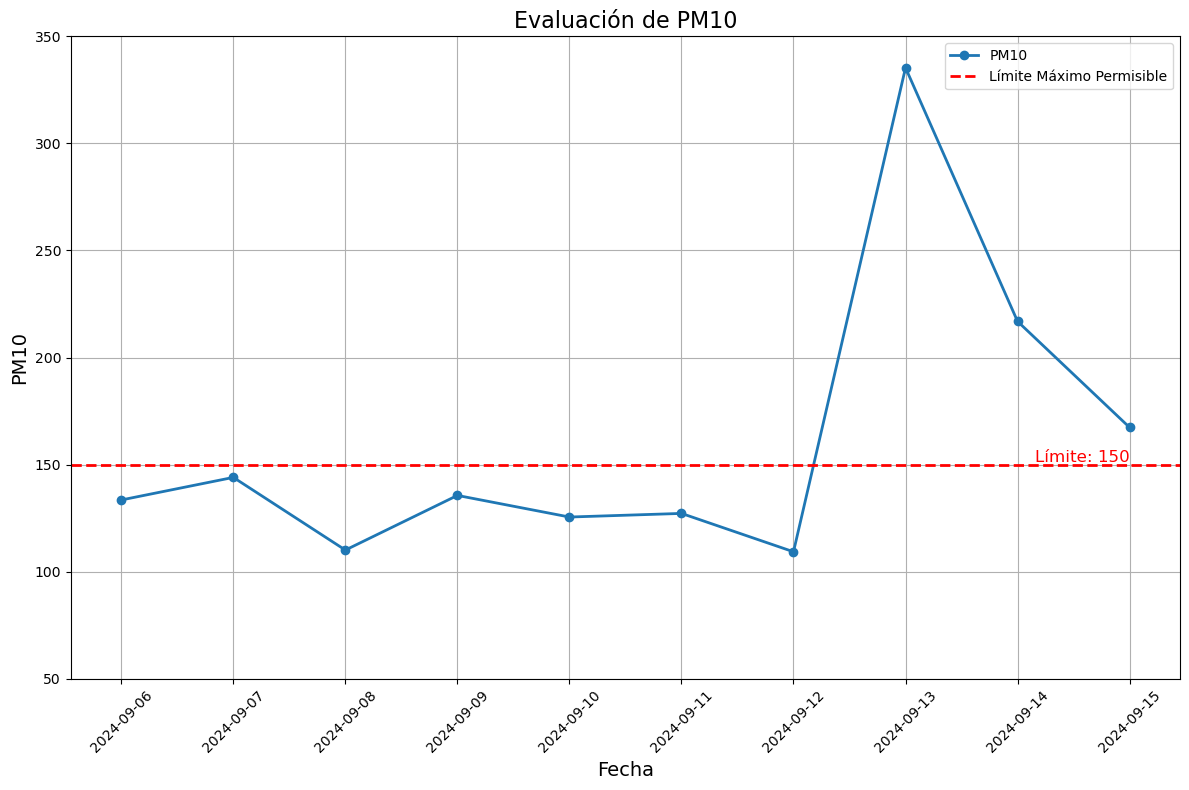

In [117]:
import matplotlib.pyplot as plt

# Crear el gráfico
plt.figure(figsize=(12, 8))

# Graficar PM2.5
plt.plot(exportar['fecha'], exportar[gas], color='tab:blue', linestyle='-', marker='o', linewidth=2, label=f'{gas}')

# Agregar línea horizontal para el límite máximo permitido
plt.axhline(y=limite, color='red', linestyle='--', linewidth=2, label='Límite Máximo Permisible')

# Agregar texto para el límite
plt.text(x=exportar['fecha'].iloc[-1], y=limite, s=f'Límite: {limite}', color='red', 
         fontsize=12, verticalalignment='bottom', horizontalalignment='right')

# Ajustar límites del gráfico
plt.ylim(bottom=50, top=350)  # Ajusta estos valores según tus datos y el límite

# Configurar etiquetas y título
plt.xlabel('Fecha', fontsize=14)
plt.ylabel(f'{gas}', fontsize=14)
plt.title(f'Evaluación de {gas}', fontsize=16)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Exportar a archivo de imagen
plt.tight_layout()
plt.savefig(f'{gas}_grafico_con_limite_nuevo.png', dpi=300)

# Mostrar el gráfico
plt.show()


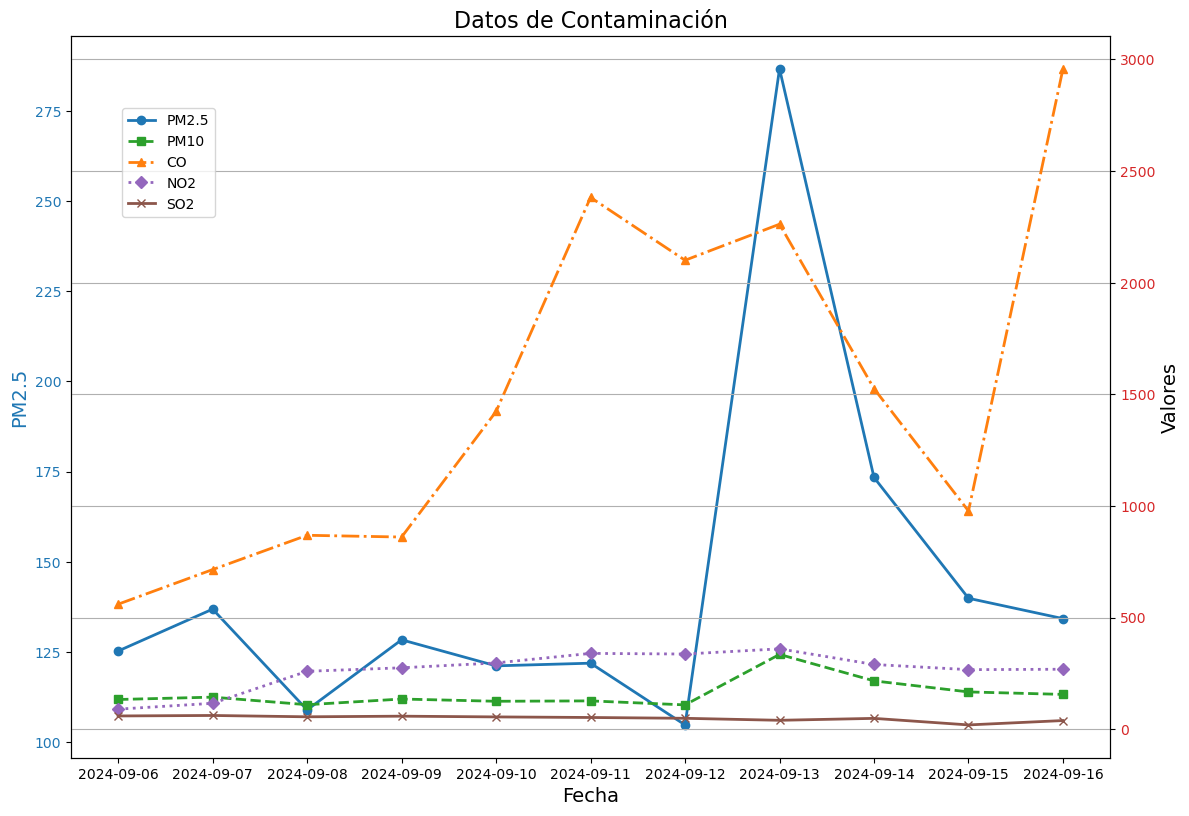

In [319]:
import matplotlib.pyplot as plt

# Crear el gráfico
fig, ax1 = plt.subplots(figsize=(12, 8))

# Graficar PM2.5 en el primer eje Y
ax1.set_xlabel('Fecha', fontsize=14)
ax1.set_ylabel('PM2.5', color='tab:blue', fontsize=14)
ax1.plot(exportar['fecha'], exportar['PM2.5'], color='tab:blue', linestyle='-', marker='o', label='PM2.5', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Crear un segundo eje Y para las otras series de datos
ax2 = ax1.twinx()
ax2.set_ylabel('Valores', fontsize=14)

# Graficar PM10, CO, NO2, y SO2 en el segundo eje Y
ax2.plot(exportar['fecha'], exportar['PM10'], color='tab:green', linestyle='--', marker='s', label='PM10', linewidth=2)
ax2.plot(exportar['fecha'], exportar['CO'], color='tab:orange', linestyle='-.', marker='^', label='CO', linewidth=2)
ax2.plot(exportar['fecha'], exportar['NO2'], color='tab:purple', linestyle=':', marker='D', label='NO2', linewidth=2)
ax2.plot(exportar['fecha'], exportar['SO2'], color='tab:brown', linestyle='-', marker='x', label='SO2', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Agregar leyenda y título
fig.tight_layout()
plt.title('Datos de Contaminación', fontsize=16)
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


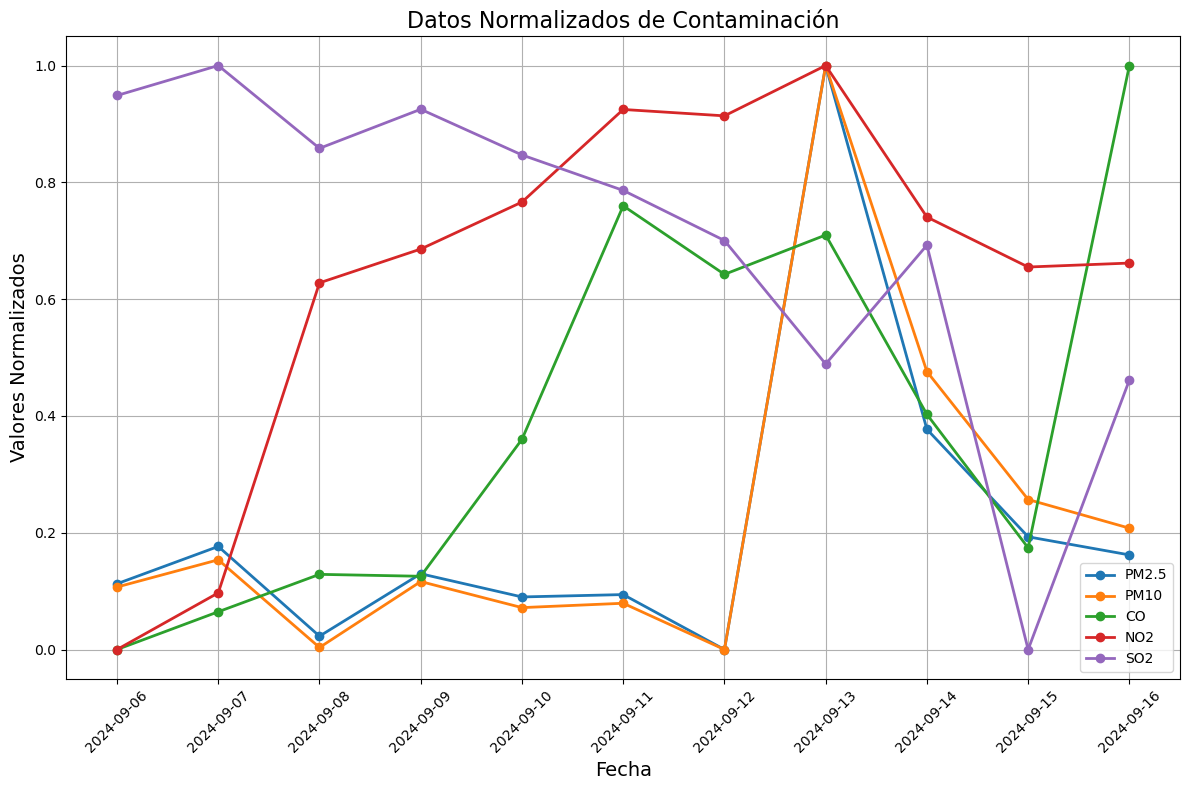

In [320]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Normalizar los datos
scaler = MinMaxScaler()
scaled_data = exportar[['PM2.5', 'PM10', 'CO', 'NO2', 'SO2']].copy()
scaled_data = scaler.fit_transform(scaled_data)

# Crear un DataFrame con los datos normalizados
scaled_df = pd.DataFrame(scaled_data, columns=['PM2.5', 'PM10', 'CO', 'NO2', 'SO2'])
scaled_df['fecha'] = exportar['fecha']

# Graficar los datos normalizados
plt.figure(figsize=(12, 8))
for column in ['PM2.5', 'PM10', 'CO', 'NO2', 'SO2']:
    plt.plot(scaled_df['fecha'], scaled_df[column], label=column, linestyle='-', marker='o', linewidth=2)

plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Valores Normalizados', fontsize=14)
plt.title('Datos Normalizados de Contaminación', fontsize=16)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [164]:
pivot_df.groupby("dia")[["PM2.5", "PM10", "CO", "NO2", "SO2"]].mean()

name,PM2.5,PM10,CO,NO2,SO2
dia,,,,,
6,69.603043,74.154348,0.050870,7.751304,59.773043
7,76.053750,80.010833,152.029167,85.592500,61.940417
8,60.538333,61.155833,868.839583,191.018333,55.941667
9,71.331250,75.331250,860.947083,202.508333,58.773750
10,67.322083,69.725000,1423.192917,218.485000,55.465000
11,67.735000,70.667083,2381.802083,249.968750,52.892917
12,58.230417,60.718333,2100.412500,247.798333,49.262083
13,286.652353,335.331176,2261.963529,270.681765,40.311176


In [152]:
pivot_df.groupby("dia")["PM10"].mean()

dia
6      74.154348
7      80.010833
8      61.155833
9      75.331250
10     69.725000
11     70.667083
12     60.718333
13    335.331176
Name: PM10, dtype: float64

In [135]:
datos31[["hour","PM2","PM10","CO","NO","SO"]].sort_values(by="hour")

,hour,PM2,PM10,CO,NO,SO
15,8,43.5366,63.3896,0,42.224,4.1055
14,9,45.8280,64.1920,0,43.526,4.2075
13,10,42.7125,66.0690,0,47.425,4.6092
12,11,44.7225,68.1150,0,52.850,4.7070
11,12,47.7375,70.5000,0,52.899,4.3470
10,13,50.2500,71.7000,0,59.270,5.0300
9,14,52.0400,73.4100,0,59.890,5.2300
8,15,57.9500,80.2400,0,60.320,4.7900
7,16,66.0200,95.2600,0,62.180,4.7600
6,17,73.2300,109.0200,0,67.750,5.1700


In [136]:
acumulado = df_merge.query("fecha.dt.day==31").copy()

In [139]:
acumulado = acumulado.query("name == 'MATERIAL PARTICULADO 10'")

In [153]:
acumulado.loc[(acumulado.fecha.dt.hour>7 & acumulado.fecha.dt.hour <=8)].value.mean()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [154]:
 acumulado.loc[(acumulado.fecha.dt.hour > 7) & (acumulado.fecha.dt.hour <= 8), "value"].mean()

97.51769811320754

In [155]:
pivot_df

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2
0,2024-08-31 07:00:00,07:00,94.848150,110.330450,0.000000,6.473047,53.355828
1,2024-08-31 08:00:00,08:00,85.546528,97.517698,1.040386,35.222671,49.160716
2,2024-08-31 09:00:00,09:00,66.480642,71.134189,1.896588,49.837261,50.277353
3,2024-08-31 10:00:00,10:00,56.346660,58.750849,0.375608,33.769560,49.086563
4,2024-08-31 11:00:00,11:00,43.269904,43.819673,0.184333,27.241791,50.306851
5,2024-08-31 12:00:00,12:00,48.963407,49.554130,0.133251,24.328236,51.604390
6,2024-08-31 13:00:00,13:00,70.766818,71.976855,0.019517,16.339508,53.030798
7,2024-08-31 14:00:00,14:00,86.268547,87.945547,0.026738,15.989767,51.973171
8,2024-08-31 15:00:00,15:00,82.709463,84.168204,0.164756,23.040625,51.527826
9,2024-08-31 16:00:00,16:00,97.113167,99.320370,0.112270,20.215995,49.768556


In [157]:
datos31.sort_values(by="hour")

,hora,PM2,PM10,SO,NO,CO,hour
15,08:00:00,43.5366,63.3896,4.1055,42.224,0,8
14,09:00:00,45.8280,64.1920,4.2075,43.526,0,9
13,10:00:00,42.7125,66.0690,4.6092,47.425,0,10
12,11:00:00,44.7225,68.1150,4.7070,52.850,0,11
11,12:00:00,47.7375,70.5000,4.3470,52.899,0,12
10,13:00:00,50.2500,71.7000,5.0300,59.270,0,13
9,14:00:00,52.0400,73.4100,5.2300,59.890,0,14
8,15:00:00,57.9500,80.2400,4.7900,60.320,0,15
7,16:00:00,66.0200,95.2600,4.7600,62.180,0,16
6,17:00:00,73.2300,109.0200,5.1700,67.750,0,17


In [1]:
import pandas as pd

In [2]:
df = pd.read_excel(r"C:\Users\ROGGER\Desktop\nuestro.xlsx")

In [5]:
senamhi = pd.read_excel(r"C:\Users\ROGGER\Desktop\ellos.xlsx")

In [7]:
df

,Fecha,Hora,PM2.5,PM10
0,2024-08-29,14:00:00,70.77,119.98
1,2024-08-29,15:00:00,50.44,96.07
2,2024-08-29,16:00:00,55.49,93.07
3,2024-08-29,17:00:00,56.51,94.86
4,2024-08-29,18:00:00,46.26,77.04
5,2024-08-29,19:00:00,41.28,68.47
6,2024-08-29,20:00:00,40.21,67.67
7,2024-08-29,21:00:00,47.27,79.74
8,2024-08-29,22:00:00,41.28,69.62
9,2024-08-29,23:00:00,70.60,121.84


In [6]:
senamhi

,Fecha,Hora,PM2.5,PM10
0,2024-08-29,14:00:00,65.77,161.95
1,2024-08-29,15:00:00,54.79,165.07
2,2024-08-29,16:00:00,46.92,115.62
3,2024-08-29,17:00:00,46.88,109.18
4,2024-08-29,18:00:00,55.08,98.15
5,2024-08-29,19:00:00,49.10,73.62
6,2024-08-29,20:00:00,43.49,64.99
7,2024-08-29,21:00:00,39.61,58.21
8,2024-08-29,22:00:00,44.13,62.77
9,2024-08-29,23:00:00,48.72,71.18


In [11]:
merged = pd.merge(df,senamhi,on=["Fecha","Hora"])

In [15]:
merged["diff_2"] = merged["PM2.5_x"] - merged["PM2.5_y"]
merged["diff_10"] = merged["PM10_x"] - merged["PM10_y"]

In [74]:
merged["diff_10"] = merged["PM10_x"] - merged["PM10_y"]

In [17]:
merged.loc[merged["diff_2"]<=0,"diff_2"] = merged["diff_2"]*-1

In [24]:
merged.loc[10,"diff_2"] = 10

In [ ]:
merged.iloc[10,"diff_2"] = merged["diff_2"]*-1

In [84]:
merged.query("diff_2 <= 10").reset_index()

,index,Fecha,Hora,PM2.5_x,PM10_x,PM2.5_y,PM10_y,diff_2,diff_10
0,0,2024-08-29,14:00:00,70.77,149.98,65.77,161.95,5.00,-11.97
1,1,2024-08-29,15:00:00,50.44,152.07,54.79,165.07,4.35,-13.00
2,2,2024-08-29,16:00:00,55.49,105.07,46.92,115.62,8.57,-10.55
3,3,2024-08-29,17:00:00,56.51,97.86,46.88,109.18,9.63,-11.32
4,4,2024-08-29,18:00:00,46.26,88.04,55.08,98.15,8.82,-10.11
5,5,2024-08-29,19:00:00,41.28,68.47,49.10,73.62,7.82,-5.15
6,6,2024-08-29,20:00:00,40.21,67.67,43.49,64.99,3.28,2.68
7,7,2024-08-29,21:00:00,47.27,64.74,39.61,58.21,7.66,6.53
8,8,2024-08-29,22:00:00,41.28,69.62,44.13,62.77,2.85,6.85
9,10,2024-08-30,00:00:00,75.81,78.68,63.16,81.68,10.00,-3.00


In [85]:
final = merged.query("diff_2 <= 10").reset_index()

In [95]:
final[["Fecha","PM2.5_x"]]

,Fecha,PM2.5_x
0,2024-08-29,70.77
1,2024-08-29,50.44
2,2024-08-29,55.49
3,2024-08-29,56.51
4,2024-08-29,46.26
5,2024-08-29,41.28
6,2024-08-29,40.21
7,2024-08-29,47.27
8,2024-08-29,41.28
9,2024-08-30,75.81


In [97]:
df

,index,Fecha,Hora,PM2.5_x,PM10_x,PM2.5_y,PM10_y,diff_2,diff_10
0,0,2024-08-29,14:00:00,70.77,149.98,65.77,161.95,5.00,-11.97
1,1,2024-08-29,15:00:00,50.44,152.07,54.79,165.07,4.35,-13.00
2,2,2024-08-29,16:00:00,55.49,105.07,46.92,115.62,8.57,-10.55
3,3,2024-08-29,17:00:00,56.51,97.86,46.88,109.18,9.63,-11.32
4,4,2024-08-29,18:00:00,46.26,88.04,55.08,98.15,8.82,-10.11
5,5,2024-08-29,19:00:00,41.28,68.47,49.10,73.62,7.82,-5.15
6,6,2024-08-29,20:00:00,40.21,67.67,43.49,64.99,3.28,2.68
7,7,2024-08-29,21:00:00,47.27,64.74,39.61,58.21,7.66,6.53
8,8,2024-08-29,22:00:00,41.28,69.62,44.13,62.77,2.85,6.85
9,10,2024-08-30,00:00:00,75.81,78.68,63.16,81.68,10.00,-3.00


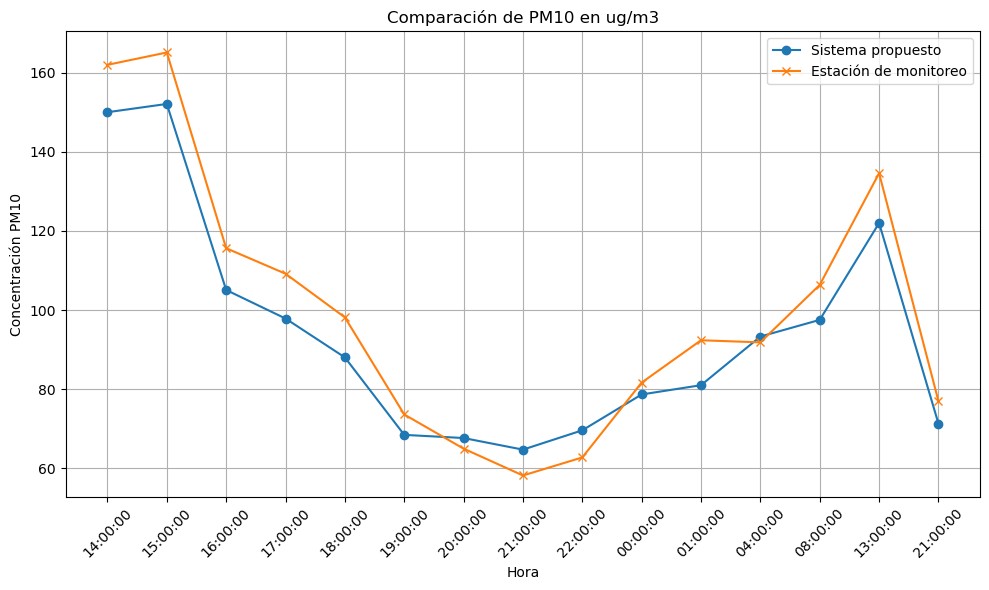

In [101]:
df = final
df['Orden'] = df.index

# Generar el gráfico con el índice 'Orden' en el eje X
plt.figure(figsize=(10,6))
plt.plot(df['Orden'], df['PM10_x'], label='Sistema propuesto', marker='o')
plt.plot(df['Orden'], df['PM10_y'], label='Estación de monitoreo', marker='x')

# Personalización del gráfico
plt.title('Comparación de PM10 en ug/m3')
plt.xlabel('Hora')
plt.ylabel('Concentración PM10')
plt.xticks(df['Orden'], df['Hora'], rotation=45)  # Mostrar las horas en el eje x
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.savefig('comparacion_pm10_nuevo.png', dpi=300)  # Puedes cambiar el nombre y el formato

plt.show()

In [102]:
correlacion_pm25 = df['PM2.5_x'].corr(df['PM2.5_y'])

In [103]:
correlacion_pm25

0.9051357173681206

In [104]:
correlacion_pm10 = df['PM10_x'].corr(df['PM10_y'])

In [105]:
correlacion_pm10

0.9881299893734921